In [1]:
import pandas as pd
import copy
import time
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.optim import Adam
import hiddenlayer as h1
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [2]:
dataset = pd.read_hdf(r"data/dataset_version1_corpus_final.hdf")

In [6]:
dataset.head()

,sentence,一级,二级,情感倾向,0,1,2,3,4,5,...,758,759,760,761,762,763,764,765,766,767
0,因为黄景瑜代言fila果断下单,精神认同,明星代言,NaN,0.002475,0.179617,0.079504,-0.454102,0.345040,-0.672276,...,-0.105042,0.029937,-0.400894,0.315450,0.542080,0.103615,0.084680,0.375346,-0.163841,-0.452431
1,耐克宣称王一博为官方合作伙伴,精神认同,明星代言,NaN,0.232284,-0.086620,-0.129583,-1.037720,0.161306,-0.038968,...,-0.327236,-0.135926,-0.421274,0.158357,-0.137306,-0.054307,-0.062343,0.342141,-0.203284,-0.364183
2,跟宋亚轩穿同款好开心,精神认同,明星代言,NaN,0.383001,0.457263,0.324387,0.051276,0.919026,-0.845025,...,-0.674936,0.294127,0.350491,-0.075102,-0.046209,-0.062519,-0.534764,0.014937,0.574544,-0.658620
3,小飞侠祝代言人肖战健康快乐每一天,精神认同,明星代言,NaN,0.940806,0.101479,-0.071435,-0.023490,0.237540,-0.979083,...,0.104352,-0.288275,-0.575316,-0.141184,-0.260583,-0.192638,-0.324006,0.306350,0.477077,-0.211201
4,活动价还是很划算的啦表白代言人李现,精神认同,明星代言,NaN,0.173127,-0.002199,-0.077387,-0.068114,0.238332,-0.650160,...,-0.083164,0.245846,0.026559,-0.097421,-0.052703,-0.296672,-0.333091,0.160364,0.186159,-0.474468


In [3]:
X = dataset.iloc[:, 4:]
tags = dataset[['一级', '二级', '情感倾向']].drop_duplicates().reset_index(drop=True).reset_index()
dataset = pd.merge(dataset, tags, how='left', on=['一级', '二级', '情感倾向'])
Y = pd.get_dummies(dataset['index'])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)

In [70]:
xt_train = torch.from_numpy(X_train.values.astype(np.float32))
xt_test = torch.from_numpy(X_test.values.astype(np.float32))
yt_train = torch.from_numpy(y_train.values.astype(np.float))
yt_test = torch.from_numpy(y_test.values.astype(np.float))

In [72]:
train_data = Data.TensorDataset(xt_train, yt_train)
train_loader = Data.DataLoader(dataset=train_data, batch_size=256, shuffle=True, num_workers=1)

In [73]:
class Mlpclassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Mlpclassifier, self).__init__()
        ## 定义第一个隐藏层
        self.hidden1 = nn.Sequential(
            nn.Linear(
                in_features = input_dim,
                out_features = 850
            ),
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(850, 400),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        self.classification = nn.Sequential(
            nn.Linear(400, output_dim)
        )
    
    def forward(self, x):
        fc1 = self.hidden1(x)
        fc2 = self.hidden2(fc1)
        output = self.classification(fc2)
        return output

In [81]:
topic_classifier = Mlpclassifier(xt_train.shape[1], yt_train.shape[1])
optimizer = Adam(topic_classifier.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss()
history1 = h1.History()
canvas1 = h1.Canvas()

In [82]:
def train_model(model, traindataloader, loss_fn, optimizer, num_epochs=60):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 999
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    since = time.time()
    for epoch in range(num_epochs):
        print('epoch {} / {}'.format(epoch, num_epochs-1))
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_num = 0
        for step, (b_x, b_y) in enumerate(traindataloader):
            model.train()
            output = model(b_x)
            loss = loss_fn(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   # 更新参数
            train_loss += loss.item() * b_x.size(0)
            train_num += b_x.size(0)
        
        model.eval()
        output = model(xt_test)
        val_loss = loss_fn(output, yt_test)
        print("epoch {}, train_loss:{:.4f}, val_loss:{:.4f}".format(epoch, train_loss/train_num, val_loss))
        history1.log(epoch, train_loss=train_loss/train_num, val_loss=val_loss)
        with canvas1:
            canvas1.draw_plot(history1['train_loss'])
            canvas1.draw_plot(history1['val_loss'])
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        time_use = time.time() - since
        print(time_use)
        
    model.load_state_dict(best_model_wts)
    print("best loss:", best_loss)
    return model            

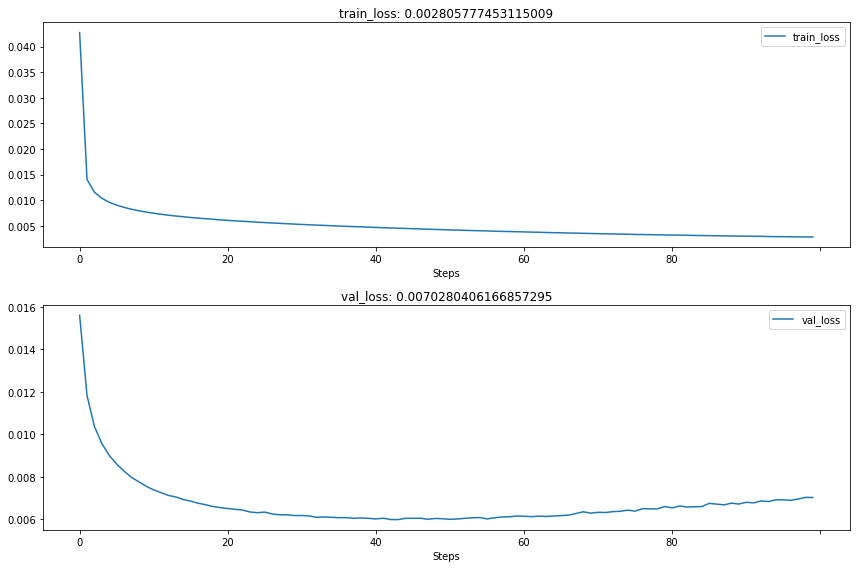

2708.7128903865814
best loss: tensor(0.0060, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [83]:
best_topic_classifier = train_model(topic_classifier, train_loader, loss_fn, optimizer, num_epochs=100)

In [163]:
torch.save(best_topic_classifier, r"model/sentence2vec_classification.pkl")

In [84]:
y_predict = best_topic_classifier(xt_test)
with torch.no_grad():
    y_predict_p = nn.Sigmoid()(y_predict)

In [109]:
y_predict_p = y_predict_p.numpy()

In [22]:
def evaluate_multi_task_prediction(y_test, y_predict_p, tags):
    evaluation_matrix = []
    for i in range(y_test.shape[1]):
        cm = confusion_matrix(y_test.values[:, i], y_predict_p[:, i] > 0.5)
        true_1 = sum(y_test.values[:, i] == 1)
        if max(cm.shape) == 2:
            true_1_predict_1 = cm[1,1]
            true1_capture = true_1_predict_1 / true_1
            predict_1 = cm[0, 1] + cm[1,1]
            real1_in_predict = true_1_predict_1 / predict_1
            dim_evaluate = list(tags.query("index == @i").values[0]) + [true_1, true_1_predict_1, true1_capture, predict_1, real1_in_predict]
            evaluation_matrix.append(dim_evaluate)
        else:   # test里没有1，预测也没1
            dim_evaluate = list(tags.query("index == @i").values[0]) + [0, 0, None, 0, None]
            evaluation_matrix.append(dim_evaluate)
    return pd.DataFrame(evaluation_matrix, columns=list(tags.columns) + ['true1', 'predict1_in_true1', 'true1_capture', 'predict1', 'real1_in_predict1'])

In [213]:
evaluation_matrix = evaluate_multi_task_prediction(y_test, y_predict_p, tags)

C:\Users\rshe11\AppData\Local\Temp\1/ipykernel_70748/133033640.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  real1_in_predict = true_1_predict_1 / predict_1
C:\Users\rshe11\AppData\Local\Temp\1/ipykernel_70748/133033640.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  real1_in_predict = true_1_predict_1 / predict_1
C:\Users\rshe11\AppData\Local\Temp\1/ipykernel_70748/133033640.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  real1_in_predict = true_1_predict_1 / predict_1
C:\Users\rshe11\AppData\Local\Temp\1/ipykernel_70748/133033640.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  real1_in_predict = true_1_predict_1 / predict_1
C:\Users\rshe11\AppData\Local\Temp\1/ipykernel_70748/133033640.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  true1_capture = true_1_predict_1 / true_1
C:\Users\rshe11\AppData\Local\Temp\1/ipykernel_70748/133033640.py:10: RuntimeWarning: invalid val

In [214]:
evaluation_matrix

,index,一级,二级,情感倾向,true1,predict1_in_true1,true1_capture,predict1,real1_in_predict1
0,0,精神认同,明星代言,NaN,600,592,0.986667,601,0.985025
1,1,精神认同,李佳琦,NaN,16,13,0.812500,14,0.928571
2,2,精神认同,国货,NaN,246,225,0.914634,232,0.969828
3,3,人群,父亲,NaN,348,259,0.744253,398,0.650754
4,4,人群,母亲,NaN,202,136,0.673267,226,0.601770
...,...,...,...,...,...,...,...,...,...
129,129,舒适,轻巧,positive,1780,1265,0.710674,1706,0.741501
130,130,舒适,轻巧,negative,51,25,0.490196,35,0.714286
131,131,舒适,透气,positive,1925,1406,0.730390,1593,0.882611
132,132,舒适,透气,negative,748,584,0.780749,702,0.831909


## 用bert词向量做feature的多任务模型

In [11]:
def get_tokenizer(name='bert-base-chinese', is_first_time=True):
    if is_first_time:
        return torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', name)
    else:
        return torch.hub.load(torch.hub.get_dir() + "/huggingface_pytorch-transformers_main", "tokenizer", name, source="local")

    
def get_model(name='bert-base-chinese', is_first_time=True):
    if is_first_time:
        return torch.hub.load('huggingface/pytorch-transformers', 'model', name)
    else:
        return torch.hub.load(torch.hub.get_dir() + "/huggingface_pytorch-transformers_main", "model", name, source="local")

In [12]:
tokenizer = get_tokenizer(name='hfl/chinese-bert-wwm-ext', is_first_time=False)
model = get_model(name='hfl/chinese-bert-wwm-ext', is_first_time=False)

Some weights of the model checkpoint at hfl/chinese-bert-wwm-ext were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
X2 = dataset["sentence"].to_list()
sen_encode_id = tokenizer.batch_encode_plus(X2, max_length=300, pad_to_max_length=True, truncation=True)
X_w2v_id = sen_encode_id['input_ids']

C:\Users\rshe11/.cache\torch\hub/huggingface_pytorch-transformers_main\src\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_w2v_id, Y, train_size=0.8)

In [15]:
xt_train2 = torch.tensor(X_train2)
xt_test2 = torch.tensor(X_test2)
yt_train2 = torch.from_numpy(y_train2.values.astype(np.float))
yt_test2 = torch.from_numpy(y_test2.values.astype(np.float))

In [304]:
# hidden = model(xt_train2[0].unsqueeze(0)).last_hidden_state.transpose(1,2)  # 1,768,300
# hidden.shape  # 1,768,300
# cnnlayer = nn.Conv1d(768, 134, 5)
# fc1 = cnnlayer(hidden)
# max_pool_layer = nn.AdaptiveMaxPool1d(1)
# fc1.shape   # 1, 134, 296
# fc2 = max_pool_layer(fc1)
# fc2.shape   # 1, 134, 1

In [18]:
class Cnnclassifier(nn.Module):
    
    def __init__(self, input_channel=768, output_channel=134):
        super(Cnnclassifier, self).__init__()
        ## 定义第一个隐藏层
        self.classification = nn.Sequential(
            nn.Conv1d(input_channel, output_channel, 5),
            nn.AdaptiveMaxPool1d(1)
        ) 
    def forward(self, x):
        output = self.classification(x)
        return output.squeeze(2)

In [70]:
# 公司电脑memorry不够，batch size只能设的很低
train_data2 = Data.TensorDataset(xt_train2, yt_train2)
train_loader2 = Data.DataLoader(dataset=train_data2, batch_size=5, shuffle=True, num_workers=0)
test_data2 = Data.TensorDataset(xt_test2, yt_test2)
test_loader2 = Data.DataLoader(dataset=test_data2, batch_size=5, shuffle=False, num_workers=0)

In [71]:
# cnn_classifier = Cnnclassifier()
cnn_classifier = torch.load("model/word2ven_classification.pkl")
optimizer = Adam(cnn_classifier.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss()
history1 = h1.History()
canvas1 = h1.Canvas()

In [72]:
def train_model2(classification_model, traindataloader, loss_fn, optimizer, num_epochs=2):
    best_model_wts = copy.deepcopy(classification_model.state_dict())
    best_loss = 999
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    since = time.time()
    for epoch in range(num_epochs):
        print('epoch {} / {}'.format(epoch, num_epochs-1))
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_num = 0
        classification_model.train()
        for step, (b_x, b_y) in enumerate(tqdm(traindataloader)):
            with torch.no_grad():
                hidden_x = model(b_x).last_hidden_state.transpose(1,2)
            output = classification_model(hidden_x)
            loss = loss_fn(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   # 更新参数
            train_loss += loss.item() * b_x.size(0)
            train_num += b_x.size(0)
        
        # test on validation dataset
        classification_model.eval()
        for step, (xt_test2_b, yt_test2_b) in enumerate(tqdm(test_loader2)):
            with torch.no_grad():
                hidden_x_test = model(xt_test2_b).last_hidden_state.transpose(1,2)
                output = classification_model(hidden_x_test)
                val_loss = loss_fn(output, yt_test2_b)
        print("epoch {}, train_loss:{:.4f}, val_loss:{:.4f}".format(epoch, train_loss / train_num, val_loss))
        history1.log(epoch, train_loss=train_loss / train_num, val_loss=val_loss)
        with canvas1:
            canvas1.draw_plot(history1['train_loss'])
            canvas1.draw_plot(history1['val_loss'])
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(classification_model.state_dict())
            classification_model.load_state_dict(best_model_wts)
            torch.save(classification_model, r"model/word2ven_classification.pkl")
        time_use = time.time() - since
        print(time_use)
        
#     classification_model.load_state_dict(best_model_wts)
    print("best loss:", best_loss)
    return classification_model           

In [ ]:
best_cnn_classifier = train_model2(cnn_classifier, train_loader2, loss_fn, optimizer, num_epochs=2)

epoch 0 / 1


 38%|██████████████████████████▊                                           | 19006/49622 [22:03:47<19:49:55,  2.33s/it]

### 测试

In [19]:
best_cnn_classifier = torch.load("model/word2ven_classification.pkl")

In [20]:
test_data2 = Data.TensorDataset(xt_test2, yt_test2)
test_loader2 = Data.DataLoader(dataset=test_data2, batch_size=2, shuffle=False, num_workers=0)
y_predict_p = []
best_cnn_classifier.eval()
for step, (test_x_b, test_y_b) in enumerate(tqdm(test_loader2)):
    with torch.no_grad():;
        hidden_x_test = model(torch.tensor(test_x_b)).last_hidden_state.transpose(1,2)
        output = best_cnn_classifier(hidden_x_test)
        y_predict_p_b = nn.Sigmoid()(output)
    y_predict_p.append(y_predict_p_b)

  0%|                                                                                        | 0/31014 [00:00<?, ?it/s]C:\Users\rshe11\AppData\Local\Temp\1/ipykernel_32580/3286046743.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hidden_x_test = model(torch.tensor(test_x_b)).last_hidden_state.transpose(1,2)
100%|██████████████████████████████████████████████████████████████████████████| 31014/31014 [7:44:30<00:00,  1.11it/s]


In [58]:
def convert_to_array(y_predict_p):
    y_predict_p2 = []
    for i in y_predict_p:
        y_predict_p2.append((list(i.numpy())))
    y_predict_p2 = np.array(list(itertools.chain(*y_predict_p2)))
    return y_predict_p2

In [64]:
y_predict_p2 = convert_to_array(y_predict_p)

evaluation_matrix = evaluate_multi_task_prediction(y_test2, np.array(y_predict_p2), tags)

C:\Users\rshe11\AppData\Local\Temp\1/ipykernel_32580/133033640.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  real1_in_predict = true_1_predict_1 / predict_1
C:\Users\rshe11\AppData\Local\Temp\1/ipykernel_32580/133033640.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  real1_in_predict = true_1_predict_1 / predict_1
C:\Users\rshe11\AppData\Local\Temp\1/ipykernel_32580/133033640.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  real1_in_predict = true_1_predict_1 / predict_1
C:\Users\rshe11\AppData\Local\Temp\1/ipykernel_32580/133033640.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  real1_in_predict = true_1_predict_1 / predict_1
C:\Users\rshe11\AppData\Local\Temp\1/ipykernel_32580/133033640.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  real1_in_predict = true_1_predict_1 / predict_1
C:\Users\rshe11\AppData\Local\Temp\1/ipykernel_32580/133033640.py:10: RuntimeWarning: inva

In [63]:
evaluation_matrix

,index,一级,二级,情感倾向,true1,predict1_in_true1,true1_capture,predict1,real1_in_predict1
0,0,精神认同,明星代言,NaN,561,521,0.928699,528,0.986742
1,1,精神认同,李佳琦,NaN,21,0,0.000000,0,NaN
2,2,精神认同,国货,NaN,262,202,0.770992,261,0.773946
3,3,人群,父亲,NaN,352,106,0.301136,133,0.796992
4,4,人群,母亲,NaN,193,0,0.000000,0,NaN
...,...,...,...,...,...,...,...,...,...
129,129,舒适,轻巧,positive,1757,430,0.244735,529,0.812854
130,130,舒适,轻巧,negative,58,0,0.000000,0,NaN
131,131,舒适,透气,positive,1898,0,0.000000,0,NaN
132,132,舒适,透气,negative,762,432,0.566929,627,0.688995
